# Übung 4a
Transfer Learning Cats and Dog Dataset

In [14]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import pathlib
from pathlib import Path
tf.random.set_seed(42)

In [17]:
!kaggle datasets download -d lucassj/dogs-vs-cats-train-validadion-and-evaluation -p ../data/cats_vs_dogs --unzip

100%|█████████████████████████████████████▉| 1.07G/1.07G [04:54<00:00, 3.20MB/s]
100%|██████████████████████████████████████| 1.07G/1.07G [04:54<00:00, 3.91MB/s]


In [18]:
data_dir = pathlib.Path("../data/cats_vs_dogs/")

In [19]:
[e.name for e in data_dir.glob("./*")]

['train', 'evaluation', 'data', 'validation']

Ändern der Dateinamen

In [20]:
!mv ../data/cats_vs_dogs/validation ../data/cats_vs_dogs/valid
!mv ../data/cats_vs_dogs/evaluation ../data/cats_vs_dogs/test
!rm -rf ../data/cats_vs_dogs/data

In [21]:
[e.name for e in data_dir.glob("./*")]

['valid', 'test', 'train']

In [22]:
CLASS_NAMES = [item.name for item in data_dir.glob('train/*')]
CLASS_NAMES

['cat', 'dog']

In [23]:
image_counts = {x: {y: len(list(data_dir.glob(x + '/' + y + '/*.jpg'))) for y in CLASS_NAMES} for x in ["train", "valid", "test"]}
image_counts

{'train': {'cat': 10000, 'dog': 10000},
 'valid': {'cat': 2500, 'dog': 2500},
 'test': {'cat': 100, 'dog': 100}}

In [25]:
import IPython.display as display
from PIL import Image

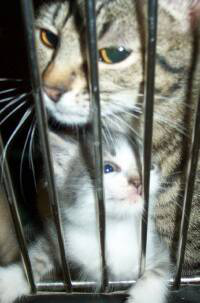

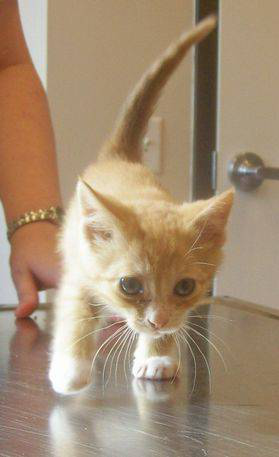

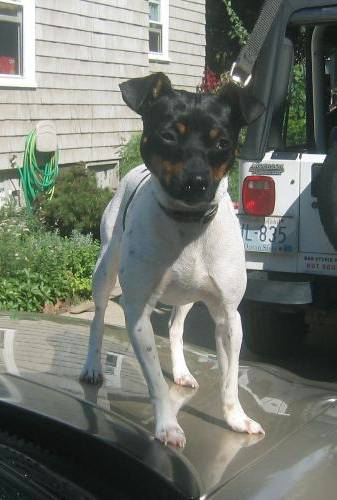

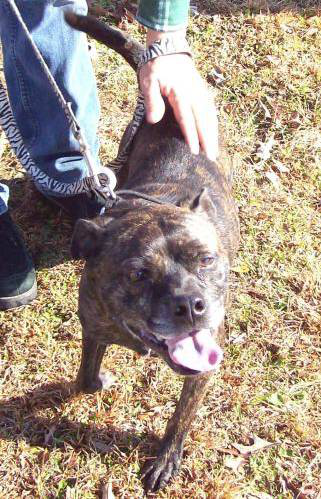

In [26]:


cats = list(data_dir.glob('test/cat/*'))
dogs = list(data_dir.glob('test/dog/*'))
both = cats[:2] + dogs[:2]

for image_path in both:
    display.display(Image.open(str(image_path)))

In [27]:
n_labels = 5000

train_cats = list(data_dir.glob('train/cat/*.jpg'))[:n_labels//2]
train_dogs = list(data_dir.glob('train/dog/*.jpg'))[:n_labels//2]
train_files = train_cats + train_dogs
train_files = [str(x) for x in train_files]

Umwandeln in Tensorflow Dataframes

In [28]:
train_ds = tf.data.Dataset.list_files(train_files)
valid_ds = tf.data.Dataset.list_files(str(data_dir/'valid/*/*.jpg'))
test_ds  = tf.data.Dataset.list_files(str(data_dir/'test/*/*.jpg'))

In [32]:
for f in train_ds.take(5):
    print(f.numpy())

b'../data/cats_vs_dogs/train/cat/cat.5489.jpg'
b'../data/cats_vs_dogs/train/cat/cat.7670.jpg'
b'../data/cats_vs_dogs/train/dog/dog.5285.jpg'
b'../data/cats_vs_dogs/train/dog/dog.3169.jpg'
b'../data/cats_vs_dogs/train/cat/cat.8430.jpg'


In [33]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    label = 1 if parts[-2] == "dog" else 0
    return label

In [34]:
def decode_img(img, IMG_WIDTH=160, IMG_HEIGHT=160):
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.cast(img, tf.float32)
    img = (img/127.5) - 1.
    return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

In [35]:
def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [36]:
train_ds = train_ds.map(process_path)
valid_ds = valid_ds.map(process_path)
test_ds  = test_ds.map(process_path)

In [37]:
BATCH_SIZE = 32
 
train_ds = train_ds.batch(BATCH_SIZE)
valid_ds = valid_ds.batch(BATCH_SIZE)
test_ds  = test_ds.batch(BATCH_SIZE)

In [38]:
for image_batch, label_batch in test_ds.take(1):
    pass

print(image_batch.shape)
label_batch.numpy()

(32, 160, 160, 3)


array([1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 0, 1, 0, 1, 0, 0, 1, 1], dtype=int32)

In [39]:
image_batch, label_batch = next(iter(train_ds))

In [40]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow((image_batch[n].numpy()+1)/2)
        plt.title(CLASS_NAMES[int(label_batch[n])])
        plt.axis('off')

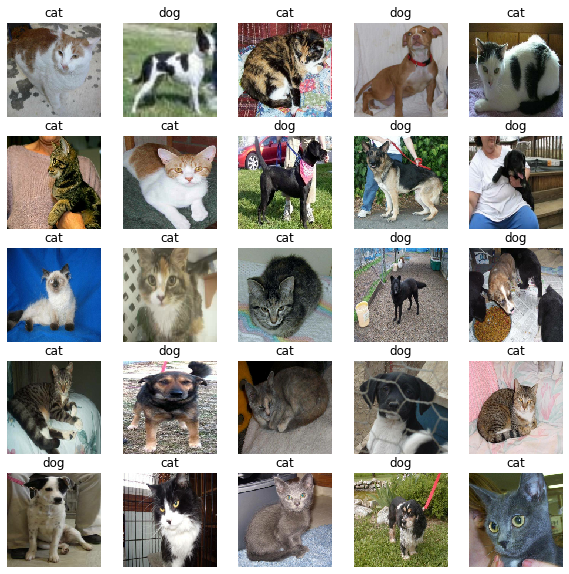

In [41]:
show_batch(image_batch, label_batch)

In [43]:
IMG_SHAPE = (160, 160, 3)

base_model = tf.keras.applications.DenseNet121(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

29089792/29084464 [==============================] - 15s 1us/step


In [44]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1024)


In [45]:
base_model.trainable = False

In [46]:
for layer in base_model.layers:
    layer.trainable = False

In [47]:
print("Number of layers in model:", len(base_model.layers))
print("="*80)
base_model.summary()

Number of layers in model: 427
Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 166, 166, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 80, 80, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 80, 80, 64)   256         conv1/conv[0][0]                 
_________________________________________________________

Das Base Model mit der Keras Application Densenet121 hat 427 Layer, was nochmal deutlich mehr als bei der MovileNet Application ist. 

In [48]:
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1024, activation="relu"),
    tf.keras.layers.Dense(1024, activation="relu"),
    tf.keras.layers.Dense(len(CLASS_NAMES), activation="softmax")
])

In [49]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 5, 5, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1049600   
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 2050      
Total params: 9,138,754
Trainable params: 2,101,250
Non-trainable params: 7,037,504
_________________________________________________________________


Das Basemodel hat schon über 7 Mio Parameter, deswegen dir die Trainingszeit auch entsprechende lange dauern.

In [50]:
optim    = tf.keras.optimizers.SGD()
loss_fct = tf.keras.losses.sparse_categorical_crossentropy
metrics  = [tf.keras.metrics.sparse_categorical_accuracy]

model.compile(optimizer = optim, loss = loss_fct, metrics = metrics)

In [51]:
loss0, accuracy0 = model.evaluate(test_ds)

7/7 [==============================] - 15s 2s/step - loss: 0.8450 - sparse_categorical_accuracy: 0.3400


In [52]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.84
initial accuracy: 0.34


Mit dem Basemodel bin ich auf eine Accuracy von 34 % gekommen und nun bin ich gespannt, welche Accuracy mit dem OnTop Model erreicht werden kann.

In [53]:
history = model.fit(train_ds, validation_data=valid_ds, epochs=5)

Train for 157 steps, validate for 157 steps
Epoch 1/5
157/157 [==============================] - 760s 5s/step - loss: 0.2039 - sparse_categorical_accuracy: 0.9116 - val_loss: 0.0898 - val_sparse_categorical_accuracy: 0.9672
Epoch 2/5
157/157 [==============================] - 701s 4s/step - loss: 0.1196 - sparse_categorical_accuracy: 0.9528 - val_loss: 0.1273 - val_sparse_categorical_accuracy: 0.9574
Epoch 3/5
157/157 [==============================] - 810s 5s/step - loss: 0.1066 - sparse_categorical_accuracy: 0.9590 - val_loss: 0.0969 - val_sparse_categorical_accuracy: 0.9678
Epoch 4/5
157/157 [==============================] - 769s 5s/step - loss: 0.0994 - sparse_categorical_accuracy: 0.9618 - val_loss: 0.0603 - val_sparse_categorical_accuracy: 0.9792
Epoch 5/5
157/157 [==============================] - 1098s 7s/step - loss: 0.0915 - sparse_categorical_accuracy: 0.9620 - val_loss: 0.0725 - val_sparse_categorical_accuracy: 0.9754


In [55]:
history_test = model.evaluate(test_ds)

7/7 [==============================] - 12s 2s/step - loss: 0.0534 - sparse_categorical_accuracy: 0.9800


Mit dem Model OnTop konnte die Accuracy auf 98% gesteigert werden. Womit die TestAccuracy sogar besser ald die Validation und TrainAccurcy ist.

In [56]:
def plot_training_curves(train_hists, test_hists, metric="sparse_categorical_accuracy"):
    """
    Helper function for plotting training curves from tf-keras history objects
    """ 
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    train_hist_loss     = sum([x.history['loss']     for x in train_hists], [])
    train_hist_val_loss = sum([x.history['val_loss'] for x in train_hists], [])
    ax[0].plot(train_hist_loss)
    ax[0].plot(train_hist_val_loss)
    for x in test_hists:
        ax[0].axhline(y=x[0], color="green", ls="--")
    ax[0].set_title('Loss history')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Train', 'Validation', 'Test'], loc='upper right')
    
    train_hist_acc     = sum([x.history[metric]          for x in train_hists], [])
    train_hist_val_acc = sum([x.history['val_' + metric] for x in train_hists], [])
    ax[1].plot(train_hist_acc)
    ax[1].plot(train_hist_val_acc)
    for x in test_hists:
        ax[1].axhline(y=x[1], color="green", ls="--")
    ax[1].set_title('Accuracy history')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Validation', 'Test'], loc='lower right')
    

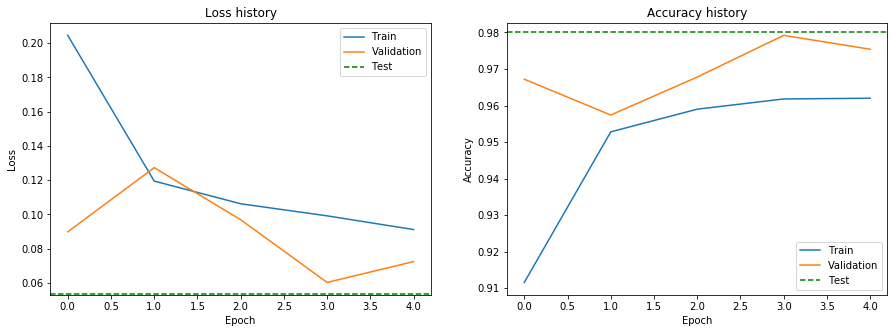

In [57]:
plot_training_curves([history], [history_test], metric="sparse_categorical_accuracy")

Ich werde noch mit einer zweiten Keras Apllication ein neues Base Modell Ausfsetzen.

In [58]:
base_model2 = tf.keras.applications.ResNet101(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

171450368/171446536 [==============================] - 60s 0us/step


In [59]:
feature_batch2 = base_model2(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1024)


In [60]:
base_model2.trainable = False

In [61]:
for layer in base_model2.layers:
    layer.trainable = False

In [62]:
print("Number of layers in model:", len(base_model2.layers))
print("="*80)
base_model2.summary()

Number of layers in model: 345
Model: "resnet101"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 166, 166, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 80, 80, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 80, 80, 64)   256         conv1_conv[0][0]                 
___________________________________________________________

Mit dem resnet Modell haben wir nun nur mehr 345 Layer. Ich bin gespannt wie dieses Modell abschneidet. Das OnTop Modell werde ich unverändert lassen.

In [63]:
model2 = tf.keras.Sequential([
    base_model2,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1024, activation="relu"),
    tf.keras.layers.Dense(1024, activation="relu"),
    tf.keras.layers.Dense(len(CLASS_NAMES), activation="softmax")
])

In [64]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet101 (Model)            (None, 5, 5, 2048)        42658176  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 2050      
Total params: 45,808,002
Trainable params: 3,149,826
Non-trainable params: 42,658,176
_________________________________________________________________


In [65]:
model2.compile(optimizer = optim, loss = loss_fct, metrics = metrics)

In [66]:
loss0, accuracy0 = model2.evaluate(test_ds)

7/7 [==============================] - 23s 3s/step - loss: 0.7375 - sparse_categorical_accuracy: 0.5000


In [67]:
print("initial loss Base Model 2: {:.2f}".format(loss0))
print("initial accuracy Base Model 2: {:.2f}".format(accuracy0))

initial loss Base Model 2: 0.74
initial accuracy Base Model 2: 0.50


Mit diesem Basemodel wurde bereits eine Accuracy von 50% erreicht.

In [68]:
history2 = model2.fit(train_ds, validation_data=valid_ds, epochs=5)

Train for 157 steps, validate for 157 steps
Epoch 1/5
157/157 [==============================] - 950s 6s/step - loss: 0.2297 - sparse_categorical_accuracy: 0.9086 - val_loss: 0.6997 - val_sparse_categorical_accuracy: 0.4978
Epoch 2/5
157/157 [==============================] - 2985s 19s/step - loss: 0.1355 - sparse_categorical_accuracy: 0.9450 - val_loss: 0.7427 - val_sparse_categorical_accuracy: 0.5000
Epoch 3/5
157/157 [==============================] - 1424s 9s/step - loss: 0.1102 - sparse_categorical_accuracy: 0.9564 - val_loss: 0.7018 - val_sparse_categorical_accuracy: 0.5012
Epoch 4/5
157/157 [==============================] - 1968s 13s/step - loss: 0.0893 - sparse_categorical_accuracy: 0.9610 - val_loss: 0.7415 - val_sparse_categorical_accuracy: 0.5000
Epoch 5/5
157/157 [==============================] - 1207s 8s/step - loss: 0.0790 - sparse_categorical_accuracy: 0.9706 - val_loss: 0.7002 - val_sparse_categorical_accuracy: 0.4954


In [69]:
history_test2 = model2.evaluate(test_ds)

7/7 [==============================] - 17s 2s/step - loss: 0.6938 - sparse_categorical_accuracy: 0.5350


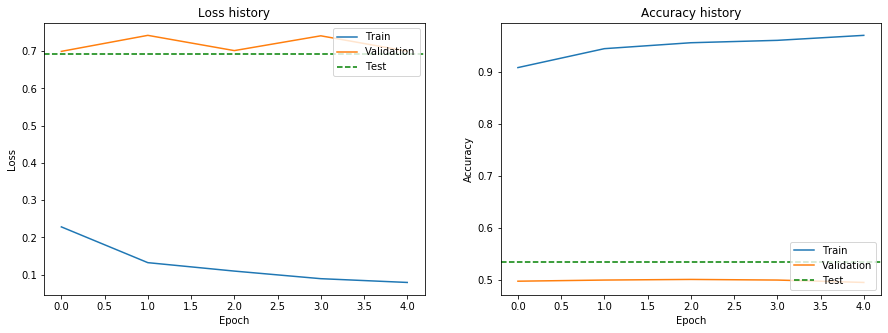

In [70]:
plot_training_curves([history2], [history_test2], metric="sparse_categorical_accuracy")

Mit diesem Modell overfitten wir sehr stark, da die Test Accuracy nu bei etwas mehr als 50% liegt.